In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# data partition
from sklearn.model_selection import train_test_split

from pandas_profiling import ProfileReport

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE


# embedded methods
from sklearn.linear_model import LassoCV

C:\Users\rodri\AppData\Local\Temp\ipykernel_32216\605863609.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
df = pd.read_csv('train_data.csv', sep=',')
df_test=pd.read_csv('test_data.csv', sep=',')
df.head()

C:\Users\rodri\AppData\Local\Temp\ipykernel_32216\2842917620.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_data.csv', sep=',')


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [6]:
df = df[~df['Claim Identifier'].duplicated()].set_index('Claim Identifier').rename_axis(None)

In [7]:
# Changing the data type of the values to string
df['Zip Code'] = df['Zip Code'].astype(str)

In [8]:
features_to_cast = ['Age at Injury', 'Birth Year', 'IME-4 Count', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'Agreement Reached']

In [12]:
for feature in features_to_cast:
    df[feature] = pd.to_numeric(df[feature], errors='coerce').astype('Int64')

In [13]:
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

for col in date_columns:
    # first, we convert the columns to datetime
    df[col] = pd.to_datetime(df[col])
    # then we convert it to int
    # df[col] = df[col].dt.strftime('%Y%m%d').astype('Int64')

In [14]:
df['Zip Code'] = df['Zip Code'].replace('nan', np.nan)

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df = df[~df['Claim Injury Type'].isna()]

### Test Split

In [30]:
X = df.drop('Claim Injury Type', axis = 1)
y = df['Claim Injury Type']

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.3, 
                                                  random_state=0, 
                                                  stratify=y)

### Outlier Removal

#### Birth Year e Age at Injury

In [37]:
X_train.shape

(401817, 31)

In [55]:
# Drop rows from X_train where both 'Age at Injury' and 'Birth Year' are 0
X_train = X_train[
    ~((X_train['Age at Injury'] == 0) & 
      (X_train['Birth Year'] == 0))
]

X_train.shape

(400356, 31)

In [57]:
X_train[X_train['Age at Injury']==0]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
5889019,2021-12-27,0.0,N,2022-01-03,Y,1187.77,<NA>,2022-01-03,NaT,AMERICAN ZURICH INSURANCE CO,...,77,MOTOR VEHICLE,90,MULTIPLE PHYSICAL INJURIES ONLY,<NA>,NaN,NaN,0,Not Work Related,3
5745409,1996-02-03,0.0,N,2021-06-15,Y,0.00,<NA>,2021-06-15,NaT,INS CO OF STATE OF PENN,...,56,LIFTING,52,STRAIN OR TEAR,33,LOWER ARM,11758.0,1,Not Work Related,5
5803752,2021-04-20,0.0,N,2021-09-03,N,0.00,<NA>,NaT,NaT,INDEMNITY INSURANCE CO OF,...,<NA>,NaN,<NA>,NaN,<NA>,NaN,11434,0,Not Work Related,3
5786811,2021-08-04,0.0,N,2021-08-12,N,0.00,<NA>,2021-08-12,NaT,INDEMNITY INSURANCE CO OF,...,57,PUSHING OR PULLING,52,STRAIN OR TEAR,<NA>,NaN,13126,0,Not Work Related,1
5825783,2021-09-27,0.0,N,2021-10-05,N,0.00,<NA>,2021-10-05,NaT,INDEMNITY INSURANCE CO OF,...,68,STATIONARY OBJECT,28,FRACTURE,<NA>,NaN,14450,0,Not Work Related,0
5400724,2020-01-08,0.0,N,2020-01-10,Y,628.62,<NA>,2020-01-10,NaT,A I U INSURANCE COMPANY,...,70,"STRIKING AGAINST OR STEPPING ON, NOC",13,CRUSHING,<NA>,NaN,11720,1,Not Work Related,6
5608170,2008-12-08,0.0,N,2020-12-01,N,0.00,<NA>,NaT,NaT,NORTHEAST HEALTH,...,<NA>,NaN,<NA>,NaN,<NA>,NaN,12306,0,Not Work Related,2
5703316,2021-03-25,0.0,N,2021-04-20,N,0.00,<NA>,2021-04-29,2021-04-15,ZURICH AMERICAN INSURANCE CO,...,50,"MOTOR VEHICLE, NOC",59,"ALL OTHER SPECIFIC INJURIES, NOC",25,SOFT TISSUE,11236,0,Not Work Related,1
5512271,2011-04-18,0.0,N,2020-07-09,N,0.00,<NA>,NaT,NaT,*** CARRIER UNDETERMINED ***,...,<NA>,NaN,<NA>,NaN,<NA>,NaN,14218,0,Not Work Related,6
6008180,2022-05-31,0.0,N,2022-06-07,N,0.00,<NA>,2022-06-07,2022-06-23,ROCHESTER REGIONAL HEALTH,...,27,FROM LIQUID OR GREASE SPILLS,10,CONTUSION,<NA>,NaN,14621,0,Not Work Related,0


In [59]:
# Função para corrigir valores faltantes entre Age at Injury e Birth Year
def fill_missing_values(row):
    # Extrair o ano da 'Accident Date'
    accident_year = pd.to_datetime(row['Accident Date']).year
    
    # Se 'Age at Injury' for 0 ou NaN e 'Birth Year' estiver presente, calcular 'Age at Injury'
    if (pd.isnull(row['Age at Injury']) or row['Age at Injury'] == 0) and pd.notnull(row['Birth Year']) and row['Birth Year'] > 0:
        row['Age at Injury'] = accident_year - row['Birth Year']
    
    # Se 'Birth Year' for 0 ou NaN e 'Age at Injury' estiver presente, calcular 'Birth Year'
    if (pd.isnull(row['Birth Year']) or row['Birth Year'] == 0) and pd.notnull(row['Age at Injury']) and row['Age at Injury'] > 0:
        row['Birth Year'] = accident_year - row['Age at Injury']
    
    return row

# Aplicar a função para cada linha do DataFrame
X_train = X_train.apply(fill_missing_values, axis=1)
X_val = X_val.apply(fill_missing_values, axis=1)


In [69]:
#check if Birth Year is consistent with Age at Injury

# Calculate the expected 'Birth Year' based on 'Accident Date' and 'Age at Injury'
X_train['Calculated Birth Year'] = X_train['Accident Date'].dt.year - X_train['Age at Injury']

# Filter rows where the absolute difference between 'Birth Year' and 'Calculated Birth Year' is greater than 1
inconsistent_df = X_train[abs(X_train['Birth Year'] - X_train['Calculated Birth Year']) > 1]

# Display the inconsistent rows
inconsistent_df[['Accident Date', 'Age at Injury', 'Birth Year', 'Calculated Birth Year']]

,Accident Date,Age at Injury,Birth Year,Calculated Birth Year


In [81]:
# Dropping errors on Age

X_train = X_train[
    (X_train['Age at Injury'] >= 14) & (X_train['Age at Injury'] <= 80)
]

X_train.shape


(397426, 32)

In [85]:
# sns.boxplot(x='Age at Injury', data=X_train)

#### Average Weekly Wage

In [89]:
# Definir o upper bound com base no percentil de 99% dos dados de treino
upper_bound = X_train['Average Weekly Wage'].quantile(0.99)

# Aplicar o capping apenas ao upper bound no conjunto de treino
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].clip(upper=upper_bound)

# Aplicar o mesmo capping ao conjunto de validação, usando o upper bound definido no treino
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].clip(upper=upper_bound)


<Axes: xlabel='Average Weekly Wage'>

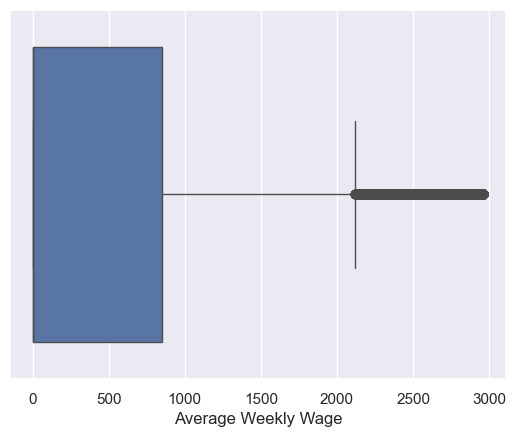

In [93]:
sns.boxplot(x='Average Weekly Wage', data=X_train)